In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.utils.data import DataLoader
#from torch.autograd import grad
import cf_matrix
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
##### LOAD #########
# choose load file name 
train_path="/home/bhagya/Cross_corpora_data_Bhagya/"
test_path="/home/bhagya/Cross_corpora_data_Bhagya/"

f1 = train_path+'X_Original_LDC_train_cms.npy'
f2 = train_path+'y_Original_LDC_train_cms.npy'
f3 = train_path+'X_train_LDC_kaldi_aug_mfcc_cms.npy'
f4 = train_path+'y_train_LDC_kaldi_aug_mfcc_cms.npy'
f5 = test_path+'X_Original_LDC_test_cms.npy'
f6 = test_path+'y_Original_LDC_test_cms.npy'

X_train = np.load(f1,allow_pickle=True)
X_aug=np.load(f3,allow_pickle=True)
X_valid = np.load(f5,allow_pickle=True)
y_train = np.load(f2,allow_pickle=True)
y_aug=np.load(f4,allow_pickle=True)
y_valid = np.load(f6,allow_pickle=True)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_aug:{X_aug.shape}, y_aug:{y_aug.shape}') 
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')

X_train:(48261, 300, 20), y_train:(48261,)
X_aug:(53852, 300, 20), y_aug:(53852,)
X_valid:(7528, 300, 20), y_valid:(7528,)


In [3]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_aug,return_counts=True))
print(np.unique(y_valid,return_counts=True))

(array([0, 1, 2, 3, 4], dtype=object), array([ 9882,  2890, 16493, 10146,  8850]))
(array([0, 1, 2, 3, 4]), array([10515,  2217, 19841, 11097, 10182]))
(array([0, 1, 2, 3, 4], dtype=object), array([1580,  696, 2560, 1343, 1349]))


In [4]:
#not doing where separate source domains are needed as X_aug such as wgdrl
X_train=np.concatenate((X_train,X_aug))
del X_aug
y_train=np.concatenate((y_train,y_aug))
del y_aug

In [5]:
print(X_train.shape)
print(np.unique(y_train,return_counts=True))

(102113, 300, 20)
(array([0, 1, 2, 3, 4], dtype=object), array([20397,  5107, 36334, 21243, 19032]))


In [6]:
#ecapa noramal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
import sys
sys.path.insert(0, "/home/bhagya/asv-subtools-master/pytorch/")
import libs.support.utils as utils
from libs.nnet import *

# refs:
# 1.  ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification
#           https://arxiv.org/abs/2005.07143
# 2.  Unofficial implementation of the ECAPA-TDNN model.
#       https://github.com/lawlict/ECAPA-TDNN




''' Res2Conv1d + BatchNorm1d + ReLU
'''
class Res2Conv1dReluBn(nn.Module):
    '''
    inputs_dim == out_channels == channels
    '''
    def __init__(self, channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False, scale=4):
        super().__init__()
        assert channels % scale == 0, "{} % {} != 0".format(channels, scale)
        self.scale = scale
        self.width = channels // scale
        self.nums = scale if scale == 1 else scale - 1

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, kernel_size, stride, padding, dilation, bias=bias))
            self.bns.append(nn.BatchNorm1d(self.width))
        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, x):
        out = []
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            # Order: conv -> relu -> bn
            sp = self.convs[i](sp)
            sp = self.bns[i](F.relu(sp))
            out.append(sp)
        if self.scale != 1:
            out.append(spx[self.nums])
        out = torch.cat(out, dim=1)
        return out



''' Conv1d + BatchNorm1d + ReLU
'''
class Conv1dReluBn(nn.Module):
    def __init__(self, inputs_dim, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(inputs_dim, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))



''' The SE connection of 1D case.
'''
class SE_Connect(nn.Module):
    def __init__(self, channels, s=4):
        super().__init__()
        assert channels % s == 0, "{} % {} != 0".format(channesl, s)
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, x):
        out = x.mean(dim=2)
        out = F.relu(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = x * out.unsqueeze(2)
        return out

#Another implementation of SE_Connect
# class SE_Connect(nn.Module):
#     def __init__(self, channels, bottleneck=128):
#         super(SE_Connect, self).__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool1d(1),
#             nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
#             nn.ReLU(),
#             # nn.BatchNorm1d(bottleneck),
#             nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
#             nn.Sigmoid(),
#             )

#     def forward(self, input):
#         x = self.se(input)
#         return input * x


''' SE-Res2Block.
    Note: residual connection is implemented in the ECAPA_TDNN model, not here.
'''
def SE_Res2Block(channels, kernel_size, stride, padding, dilation, scale):
    return nn.Sequential(
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        Res2Conv1dReluBn(channels, kernel_size, stride, padding, dilation, scale=scale),
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        SE_Connect(channels)
    )



''' Attentive weighted mean and standard deviation pooling.
'''
class AttentiveStatsPool(nn.Module):
    def __init__(self, in_dim, bottleneck_dim):
        super().__init__()
        # Use Conv1d with stride == 1 rather than Linear, then we don't need to transpose inputs.
        self.linear1 = nn.Conv1d(in_dim, bottleneck_dim, kernel_size=1) # equals W and b in the paper
        self.linear2 = nn.Conv1d(bottleneck_dim, in_dim, kernel_size=1) # equals V and k in the paper

    def forward(self, x):
        # DON'T use ReLU here! In experiments, I find ReLU hard to converge.
        alpha = torch.tanh(self.linear1(x))
        alpha = torch.softmax(self.linear2(alpha), dim=2)
        mean = torch.sum(alpha * x, dim=2)
        residuals = torch.sum(alpha * x ** 2, dim=2) - mean ** 2
        std = torch.sqrt(residuals.clamp(min=1e-9))
        return torch.cat([mean, std], dim=1)



''' Implementation of
    "ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification".

    Note that we DON'T concatenate the last frame-wise layer with non-weighted mean and standard deviation,
    because it brings little improvment but significantly increases model parameters.
    As a result, this implementation basically equals the A.2 of Table 2 in the paper.
'''
class ECAPA_TDNN(TopVirtualNnet):
    def init(self, inputs_dim, num_targets, channels=512, embd_dim=192,
             aug_dropout=0.5, tail_dropout=0.5, training=True,
             extracted_embedding="near", mixup=False, mixup_alpha=1.0,
             pooling="ecpa-attentive", pooling_params={}, fc1=False, fc1_params={}, fc2_params={},
             margin_loss= True, margin_loss_params={}, use_step=False, step_params={}, transfer_from="softmax_loss" ):


        default_pooling_params = {
            "num_head":1,
            "hidden_size":64,
            "share":True,
            "affine_layers":1,
            "context":[0],
            "stddev":True,
            "temperature":False,
            "fixed":True
        }

        default_fc_params = {
            "nonlinearity":'relu', "nonlinearity_params":{"inplace":True},
            "bn-relu":False,
            "bn":True,
            "bn_params":{"momentum":0.5, "affine":True, "track_running_stats":True}
            }


        default_margin_loss_params = {
            "method":"am", "m":0.2,
            "feature_normalize":True, "s":30,
            "double":False,
            "mhe_loss":False, "mhe_w":0.01,
            "inter_loss":0.,
            "ring_loss":0.,
            "curricular":False}

        default_step_params = {
            "T":None,
            "m":False, "lambda_0":0, "lambda_b":1000, "alpha":5, "gamma":1e-4,
            "s":False, "s_tuple":(30, 12), "s_list":None,
            "t":False, "t_tuple":(0.5, 1.2),
            "p":False, "p_tuple":(0.5, 0.1)
        }

        self.use_step = use_step
        self.step_params = step_params
        self.extracted_embedding = extracted_embedding

        pooling_params = utils.assign_params_dict(default_pooling_params, pooling_params)
        fc1_params = utils.assign_params_dict(default_fc_params, fc1_params)
        fc2_params = utils.assign_params_dict(default_fc_params, fc2_params)
        margin_loss_params = utils.assign_params_dict(default_margin_loss_params, margin_loss_params)
        step_params = utils.assign_params_dict(default_step_params, step_params)


        #self.mixup = Mixup(alpha=mixup_alpha) if mixup else None
        #self.pcmvn = AdaptivePCMN(20)
        self.layer1 = Conv1dReluBn(inputs_dim, channels, kernel_size=5, padding=2)
        self.layer2 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=2, dilation=2, scale=8)
        self.layer3 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=3, dilation=3, scale=8)
        self.layer4 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=4, dilation=4, scale=8)
        cat_channels = channels * 3
        self.conv = nn.Conv1d(cat_channels, cat_channels, kernel_size=1)
        self.bn_conv = nn.BatchNorm1d(cat_channels)

        # Pooling
        stddev = pooling_params.pop("stddev")
        if pooling == "attentive":
            self.stats = AttentiveStatisticsPooling(cat_channels, hidden_size=pooling_params["hidden_size"],context=pooling_params["context"], stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "ecpa-attentive":
            self.stats = AttentiveStatsPool(cat_channels,128)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-head":
            self.stats = MultiHeadAttentionPooling(cat_channels, stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "global-multi":
            self.stats = GlobalMultiHeadAttentionPooling(cat_channels,stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-resolution":
            self.stats = MultiResolutionMultiHeadAttentionPooling(cat_channels, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None

        else:
            self.stats = StatisticsPooling(cat_channels, stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None

        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

        if fc1:
            fc2_in_dim = embd_dim
        else:
            fc2_in_dim = cat_channels * 2
        self.fc2 = ReluBatchNormTdnnLayer(fc2_in_dim, embd_dim, **fc2_params)
        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

         # Loss
        # Do not need when extracting embedding.
        if training :
            if margin_loss:
                self.loss = MarginSoftmaxLoss(embd_dim, num_targets, **margin_loss_params)
            else:
                self.loss = SoftmaxLoss(embd_dim, num_targets)
                # self.loss = AngleLoss(embd_dim,num_targets)
            self.wrapper_loss = MixupLoss(self.loss, self.mixup) if mixup else None
            # An example to using transform-learning without initializing loss.affine parameters
            self.transform_keys = ["layer2","layer3","layer4","conv","stats","fc1","fc2"]

            if margin_loss and transfer_from == "softmax_loss":
                # For softmax_loss to am_softmax_loss
                self.rename_transform_keys = {"loss.affine.weight":"loss.weight"}

    @utils.for_device_free
    def forward(self, x):
        #x = self.mixup(x)
        #x = self.pcmvn(x)
        out1 = self.layer1(x)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        x = self.auto(self.fc1, x)
        x = self.fc2(x)
        x = self.auto(self.tail_dropout, x)
        return x

    @utils.for_device_free
    def get_loss(self, inputs, targets):
        """Should call get_loss() after forward() with using Xvector model function.
        e.g.:
            m=Xvector(20,10)
            loss=m.get_loss(m(inputs),targets)

        model.get_loss [custom] -> loss.forward [custom]
          |
          v
        model.get_accuracy [custom] -> loss.get_accuracy [custom] -> loss.compute_accuracy [static] -> loss.predict [static]
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss(inputs, targets)
        else:
            return self.loss(inputs, targets)

    @utils.for_device_free
    def get_accuracy(self, targets):
        """Should call get_accuracy() after get_loss().
        @return: return accuracy
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss.get_accuracy(targets)
        else:
            return self.loss.get_accuracy(targets)

    @for_extract_embedding(maxChunk=10000, isMatrix=True)
    def extract_embedding(self, inputs):
        out1 = self.layer1(inputs)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        if self.extracted_embedding == "far":
            assert self.fc1 is not None
            xvector = self.fc1.affine(x)
        elif self.extracted_embedding == "near_affine":
            x = self.auto(self.fc1, x)
            xvector = self.fc2.affine(x)
        elif self.extracted_embedding == "near":
            x = self.auto(self.fc1, x)
            xvector = self.fc2(x)
        else:
            raise TypeError("Expected far or near position, but got {}".format(self.extracted_embedding))
        return xvector
    def get_warmR_T(T_0, T_mult, epoch):
        n = int(math.log(max(0.05, (epoch / T_0 * (T_mult - 1) + 1)), T_mult))
        T_cur = epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
        T_i = T_0 * T_mult ** (n)
        return T_cur, T_i

    def compute_decay_value(self, start, end, T_cur, T_i):
        # Linear decay in every cycle time.
        return start - (start - end)/(T_i-1) * (T_cur%T_i)

    def step(self, epoch, this_iter, epoch_batchs):
        # Heated up for t and s.
        # Decay for margin and dropout p.
        if self.use_step:
            if self.step_params["m"]:
                current_postion = epoch*epoch_batchs + this_iter
                lambda_factor = max(self.step_params["lambda_0"],
                                 self.step_params["lambda_b"]*(1+self.step_params["gamma"]*current_postion)**(-self.step_params["alpha"]))
                self.loss.step(lambda_factor)

            if self.step_params["T"] is not None and (self.step_params["t"] or self.step_params["p"]):
                T_cur, T_i = get_warmR_T(*self.step_params["T"], epoch)
                T_cur = T_cur*epoch_batchs + this_iter
                T_i = T_i * epoch_batchs

            if self.step_params["t"]:
                self.loss.t = self.compute_decay_value(*self.step_params["t_tuple"], T_cur, T_i)

            if self.step_params["p"]:
                self.aug_dropout.p = self.compute_decay_value(*self.step_params["p_tuple"], T_cur, T_i)

            if self.step_params["s"]:
                self.loss.s = self.step_params["s_tuple"][self.step_params["s_list"][epoch]]


if __name__ == '__main__':
    # Input size: batch_size * seq_len * feat_dim
    x = torch.zeros(2, 20, 300)
    model = ECAPA_TDNN(inputs_dim=20,num_targets=5, channels=512, embd_dim=192)
    out = model(x)
    print(model)
    print(out.shape)    # should be [2, 192]

ECAPA_TDNN(
  (layer1): Conv1dReluBn(
    (conv): Conv1d(20, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0-6): 7 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      )
      (bns): ModuleList(
        (0-6): 7 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): SE_Connect(
      (linear1): Linear(in_features=512

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [7]:
def imbalance_class_weight(y,tot_class):
    classes=np.unique(y,return_counts=True)
    total_samples=np.sum(np.array(classes[1]))
    class_weights=np.empty(tot_class)
    for i,j in enumerate(classes[1]):
        print(i,'--->',j)
        class_weights[i]=total_samples/(tot_class*j)
    print(class_weights)
    return class_weights

In [8]:
class_weights_train=imbalance_class_weight(y_train,5)
class_weights_train2=class_weights_train/np.max(class_weights_train)
print(class_weights_train2)

0 ---> 20397
1 ---> 5107
2 ---> 36334
3 ---> 21243
4 ---> 19032
[1.00125509 3.99894263 0.56207959 0.96138022 1.07306641]
[0.25037996 1.         0.14055705 0.24040861 0.26833754]


In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#deice=torch.device("cpu")
model = ECAPA_TDNN(20, 5).to(device)
class_weights_train = torch.FloatTensor(class_weights_train2).to(device)
loss_fun = nn.CrossEntropyLoss(weight=class_weights_train)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=0.0000001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [10]:
def xv_data_manage(X_test):
     aa=X_test.transpose((0,2,1))
     print(X_test.shape, '-->', aa.shape)
     return aa

In [11]:
 X_train=xv_data_manage(X_train)
 X_valid=xv_data_manage(X_valid)

(102113, 300, 20) --> (102113, 20, 300)
(7528, 300, 20) --> (7528, 20, 300)


In [12]:
trainloader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=300,drop_last=False)
testloader1 = torch.utils.data.DataLoader(list(zip(X_valid,y_valid)), shuffle=False, batch_size=32,drop_last=False)
#testloader2 = torch.utils.data.DataLoader(list(zip(X_test,y_test)), shuffle=True, batch_size=32,drop_last=False)
print(len(trainloader))
print(len(testloader1))
#print(len(testloader2))
#print(len(testloader3))

341
236


Epoch: 0, Batch: 0, Loss: 8.669818878173828, Accuracy:22.666666666666664%
Epoch: 0, Batch: 50, Loss: 5.663978099822998, Accuracy:57.99999999999999%
Epoch: 0, Batch: 100, Loss: 5.1769490242004395, Accuracy:62.0%
Epoch: 0, Batch: 150, Loss: 5.01101541519165, Accuracy:64.33333333333333%
Epoch: 0, Batch: 200, Loss: 3.839932441711426, Accuracy:74.33333333333333%
Epoch: 0, Batch: 250, Loss: 3.9877521991729736, Accuracy:75.66666666666667%
Epoch: 0, Batch: 300, Loss: 3.922222137451172, Accuracy:72.0%
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 5.966989994049072, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 0, Batch: 50, Loss: 5.592803478240967, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 0, Batch: 100, Loss: 7.8649139404296875, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 0, Batch: 150, Loss: 3.01840877532959, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 0, Batch: 200, Loss: 0.8939201235771179, Accuracy:81.25%


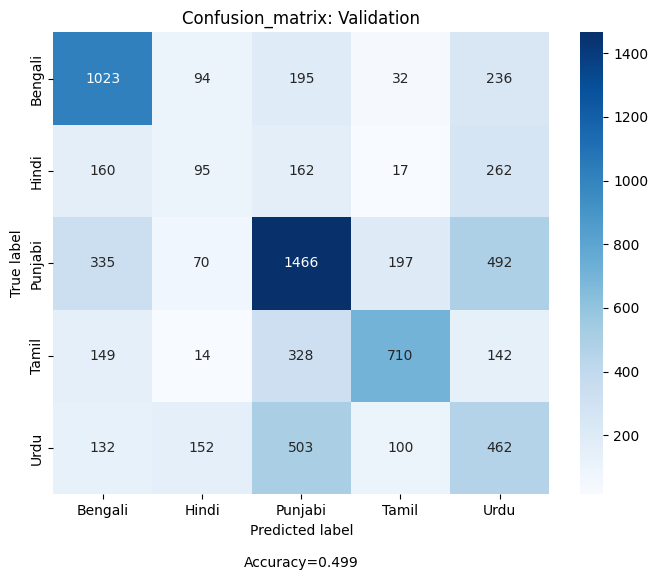

:::::Total vlidation loss 3.5063397614563594, Training accuracy 0.6420436183443832, Validation accuracy 0.4989373007438895 after 0 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 1, Batch: 0, Loss: 3.518221855163574, Accuracy:73.33333333333333%
Epoch: 1, Batch: 50, Loss: 3.472430467605591, Accuracy:76.0%
Epoch: 1, Batch: 100, Loss: 3.0660200119018555, Accuracy:78.33333333333333%
Epoch: 1, Batch: 150, Loss: 2.9134445190429688, Accuracy:83.0%
Epoch: 1, Batch: 200, Loss: 2.773144483566284, Accuracy:79.66666666666666%
Epoch: 1, Batch: 250, Loss: 2.9680099487304688, Accuracy:79.66666666666666%
Epoch: 1, Batch: 300, Loss: 2.63421630859375, Accuracy:81.33333333333333%
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 6.40899658203125, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 1, Batch: 50, Loss: 5.110677719116211, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 1, Batch: 100, Loss: 10.786825180053711, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 1, Bat

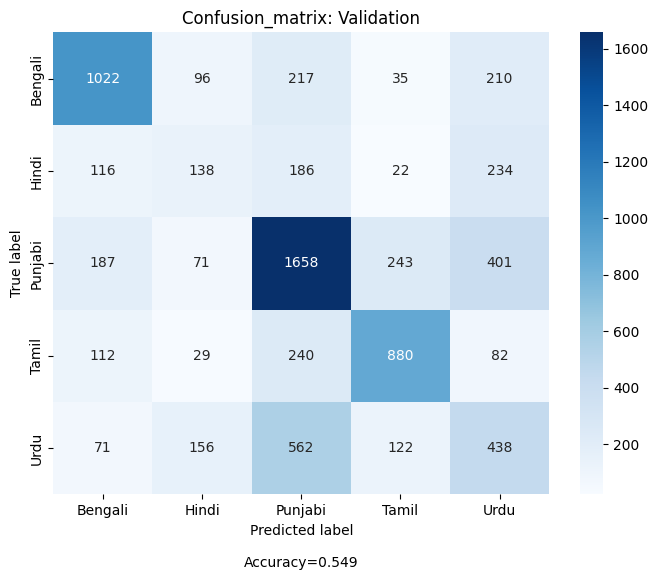

:::::Total vlidation loss 3.4956064807923495, Training accuracy 0.7933074143350993, Validation accuracy 0.5494155154091392 after 1 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 2, Batch: 0, Loss: 2.4293813705444336, Accuracy:83.66666666666667%
Epoch: 2, Batch: 50, Loss: 2.837308406829834, Accuracy:81.0%
Epoch: 2, Batch: 100, Loss: 2.0259647369384766, Accuracy:86.33333333333333%
Epoch: 2, Batch: 150, Loss: 2.7222299575805664, Accuracy:83.33333333333334%
Epoch: 2, Batch: 200, Loss: 2.2182066440582275, Accuracy:85.33333333333334%
Epoch: 2, Batch: 250, Loss: 2.342604160308838, Accuracy:83.66666666666667%
Epoch: 2, Batch: 300, Loss: 2.1719017028808594, Accuracy:86.66666666666667%
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 6.103867530822754, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 2, Batch: 50, Loss: 7.022995471954346, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 2, Batch: 100, Loss: 9.231822967529297, Accuracy:18.75%
#####TEST--in-domain:::::E

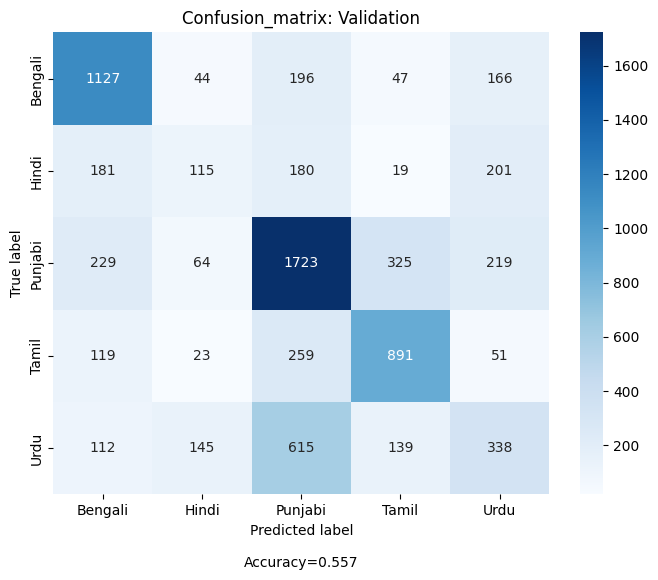

:::::Total vlidation loss 3.8737173581077418, Training accuracy 0.8497742696816272, Validation accuracy 0.5571200850159405 after 2 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 3, Batch: 0, Loss: 2.130138635635376, Accuracy:87.33333333333333%
Epoch: 3, Batch: 50, Loss: 2.108384132385254, Accuracy:86.66666666666667%
Epoch: 3, Batch: 100, Loss: 1.9647985696792603, Accuracy:86.66666666666667%
Epoch: 3, Batch: 150, Loss: 1.6766716241836548, Accuracy:87.66666666666667%
Epoch: 3, Batch: 200, Loss: 1.7611961364746094, Accuracy:89.66666666666666%
Epoch: 3, Batch: 250, Loss: 1.501189947128296, Accuracy:89.66666666666666%
Epoch: 3, Batch: 300, Loss: 1.4607213735580444, Accuracy:91.33333333333333%
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 4.58252477645874, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 3, Batch: 50, Loss: 7.017213344573975, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 3, Batch: 100, Loss: 15.127134323120117, Accuracy:9.375%
#####TEST--in-

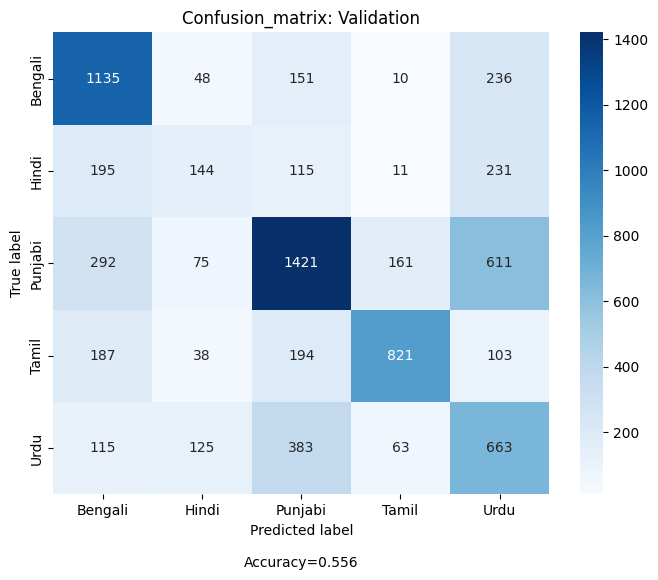

:::::Total vlidation loss 4.0269781437816645, Training accuracy 0.8841675398822872, Validation accuracy 0.5557917109458024 after 3 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 4, Batch: 0, Loss: 1.4752742052078247, Accuracy:91.66666666666666%
Epoch: 4, Batch: 50, Loss: 1.6921391487121582, Accuracy:89.33333333333333%
Epoch: 4, Batch: 100, Loss: 1.6984676122665405, Accuracy:88.33333333333333%
Epoch: 4, Batch: 150, Loss: 1.3259327411651611, Accuracy:92.0%
Epoch: 4, Batch: 200, Loss: 1.5044842958450317, Accuracy:90.66666666666666%
Epoch: 4, Batch: 250, Loss: 1.4980506896972656, Accuracy:91.0%
Epoch: 4, Batch: 300, Loss: 1.1511693000793457, Accuracy:93.33333333333333%
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 5.2577362060546875, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 4, Batch: 50, Loss: 10.82151985168457, Accuracy:0.0%
#####TEST--in-domain:::::Epoch: 4, Batch: 100, Loss: 13.148756980895996, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 4

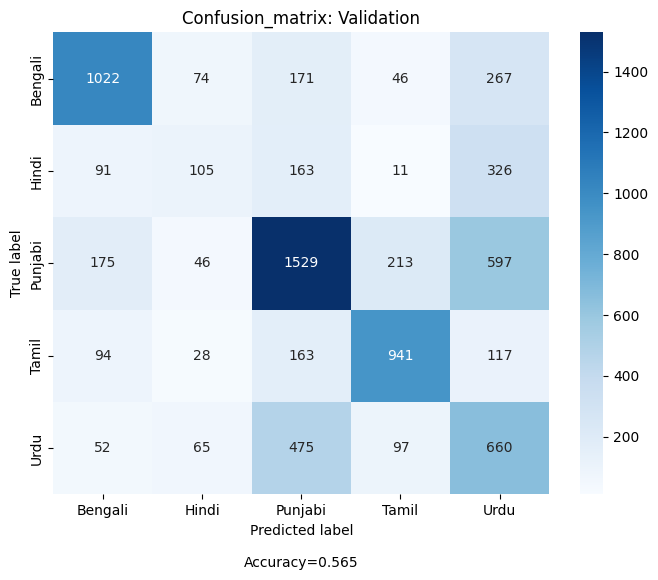

:::::Total vlidation loss 4.214921733521923, Training accuracy 0.9103444223556256, Validation accuracy 0.5654888416578109 after 4 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 5, Batch: 0, Loss: 1.152274489402771, Accuracy:93.66666666666667%
Epoch: 5, Batch: 50, Loss: 1.2381237745285034, Accuracy:91.66666666666666%
Epoch: 5, Batch: 100, Loss: 1.06446373462677, Accuracy:93.66666666666667%
Epoch: 5, Batch: 150, Loss: 0.993147611618042, Accuracy:93.66666666666667%
Epoch: 5, Batch: 200, Loss: 1.2772754430770874, Accuracy:91.33333333333333%
Epoch: 5, Batch: 250, Loss: 1.1789062023162842, Accuracy:92.33333333333333%
Epoch: 5, Batch: 300, Loss: 0.944754958152771, Accuracy:93.66666666666667%
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 7.38111686706543, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 5, Batch: 50, Loss: 6.8292694091796875, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 5, Batch: 100, Loss: 12.806437492370605, Accuracy:18.75%
#####TEST--i

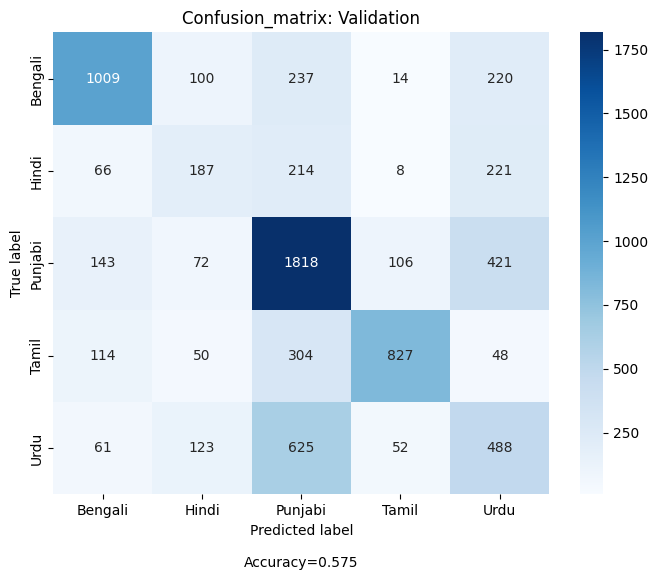

:::::Total vlidation loss 4.335967518211847, Training accuracy 0.9306846336901275, Validation accuracy 0.5750531349628055 after 5 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 6, Batch: 0, Loss: 0.7952193021774292, Accuracy:95.33333333333334%
Epoch: 6, Batch: 50, Loss: 0.6468456983566284, Accuracy:96.33333333333334%
Epoch: 6, Batch: 100, Loss: 0.8690352439880371, Accuracy:95.66666666666667%
Epoch: 6, Batch: 150, Loss: 0.7379117608070374, Accuracy:95.0%
Epoch: 6, Batch: 200, Loss: 0.9809151291847229, Accuracy:94.33333333333334%
Epoch: 6, Batch: 250, Loss: 0.8063487410545349, Accuracy:96.33333333333334%
Epoch: 6, Batch: 300, Loss: 0.8030557036399841, Accuracy:95.33333333333334%
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 4.677772521972656, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 6, Batch: 50, Loss: 5.227962970733643, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 6, Batch: 100, Loss: 13.505615234375, Accuracy:12.5%
#####TEST--in-domain::::

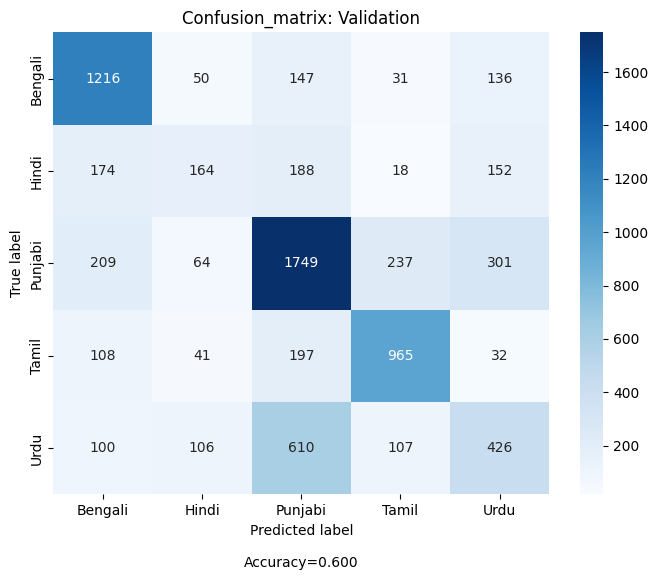

:::::Total vlidation loss 4.131156629161283, Training accuracy 0.9472055467961964, Validation accuracy 0.6004250797024442 after 6 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 7, Batch: 0, Loss: 0.5318532586097717, Accuracy:97.0%
Epoch: 7, Batch: 50, Loss: 0.5737396478652954, Accuracy:96.66666666666667%
Epoch: 7, Batch: 100, Loss: 0.6201598644256592, Accuracy:96.66666666666667%
Epoch: 7, Batch: 150, Loss: 0.5976849794387817, Accuracy:96.0%
Epoch: 7, Batch: 200, Loss: 0.6519873142242432, Accuracy:96.33333333333334%
Epoch: 7, Batch: 250, Loss: 0.5462358593940735, Accuracy:97.0%
Epoch: 7, Batch: 300, Loss: 0.6919817924499512, Accuracy:95.66666666666667%
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 7.338161945343018, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 7, Batch: 50, Loss: 9.948897361755371, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 7, Batch: 100, Loss: 15.487424850463867, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 7, Batch: 150, 

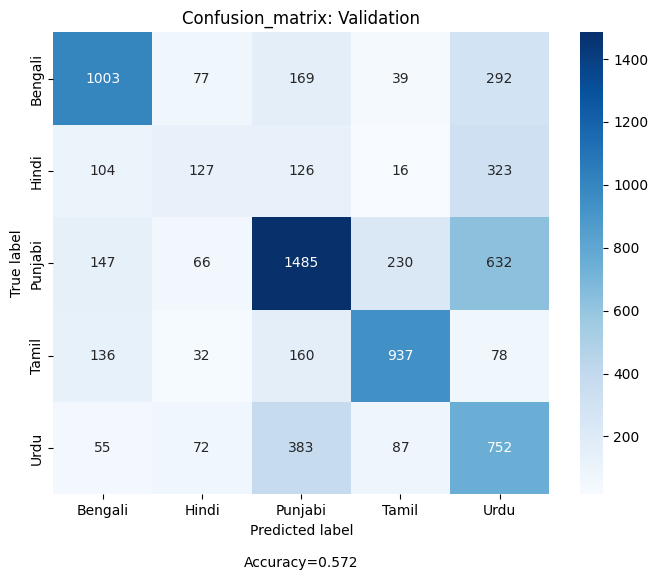

:::::Total vlidation loss 4.7989623227000715, Training accuracy 0.9592118535348094, Validation accuracy 0.5717321997874601 after 7 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 8, Batch: 0, Loss: 0.4781474769115448, Accuracy:98.33333333333333%
Epoch: 8, Batch: 50, Loss: 0.34214484691619873, Accuracy:99.0%
Epoch: 8, Batch: 100, Loss: 0.7783305644989014, Accuracy:94.33333333333334%
Epoch: 8, Batch: 150, Loss: 0.6723430752754211, Accuracy:97.0%
Epoch: 8, Batch: 200, Loss: 0.5994834899902344, Accuracy:95.66666666666667%
Epoch: 8, Batch: 250, Loss: 0.5418974757194519, Accuracy:97.0%
Epoch: 8, Batch: 300, Loss: 0.49385687708854675, Accuracy:97.33333333333334%
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 3.1433937549591064, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 8, Batch: 50, Loss: 6.365025520324707, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 8, Batch: 100, Loss: 12.362395286560059, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 150, 

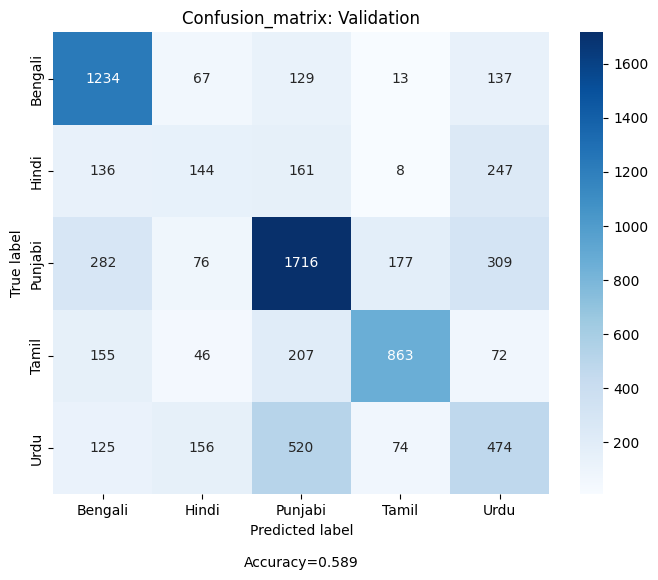

:::::Total vlidation loss 4.685033107034422, Training accuracy 0.9698667162849001, Validation accuracy 0.5886025504782146 after 8 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 9, Batch: 0, Loss: 0.3810310661792755, Accuracy:98.33333333333333%
Epoch: 9, Batch: 50, Loss: 0.28328701853752136, Accuracy:98.66666666666667%
Epoch: 9, Batch: 100, Loss: 0.2524649202823639, Accuracy:98.66666666666667%
Epoch: 9, Batch: 150, Loss: 0.35331785678863525, Accuracy:97.33333333333334%
Epoch: 9, Batch: 200, Loss: 0.24472440779209137, Accuracy:98.66666666666667%
Epoch: 9, Batch: 250, Loss: 0.20813952386379242, Accuracy:99.0%
Epoch: 9, Batch: 300, Loss: 0.41049760580062866, Accuracy:97.66666666666667%
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 5.221136093139648, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 9, Batch: 50, Loss: 8.527471542358398, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 9, Batch: 100, Loss: 11.696436882019043, Accuracy:25.0%
#####TEST--in-doma

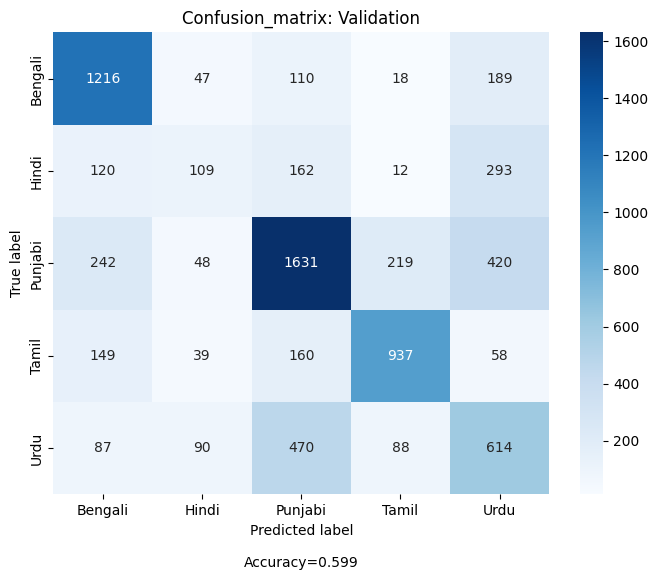

:::::Total vlidation loss 4.758727726437663, Training accuracy 0.9866912146347674, Validation accuracy 0.5986981934112646 after 9 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 10, Batch: 0, Loss: 0.17651037871837616, Accuracy:98.66666666666667%
Epoch: 10, Batch: 50, Loss: 0.1627577841281891, Accuracy:99.66666666666667%
Epoch: 10, Batch: 100, Loss: 0.185926616191864, Accuracy:99.33333333333333%
Epoch: 10, Batch: 150, Loss: 0.19751094281673431, Accuracy:99.66666666666667%
Epoch: 10, Batch: 200, Loss: 0.1561964750289917, Accuracy:100.0%
Epoch: 10, Batch: 250, Loss: 0.3083547055721283, Accuracy:98.0%
Epoch: 10, Batch: 300, Loss: 0.25250691175460815, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 5.755122661590576, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 10, Batch: 50, Loss: 6.870146751403809, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 10, Batch: 100, Loss: 11.819330215454102, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 1

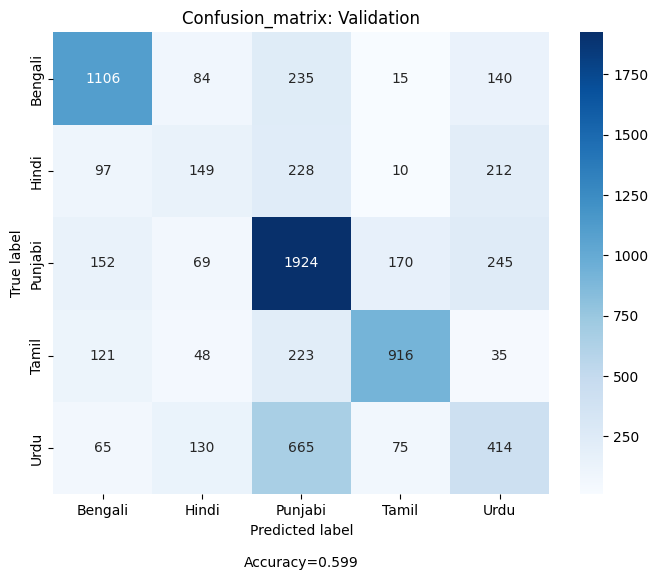

:::::Total vlidation loss 4.956427751204376, Training accuracy 0.9910883041336559, Validation accuracy 0.5989638682252922 after 10 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 11, Batch: 0, Loss: 0.11365043371915817, Accuracy:99.66666666666667%
Epoch: 11, Batch: 50, Loss: 0.13948971033096313, Accuracy:99.66666666666667%
Epoch: 11, Batch: 100, Loss: 0.17946884036064148, Accuracy:99.66666666666667%
Epoch: 11, Batch: 150, Loss: 0.10824218392372131, Accuracy:100.0%
Epoch: 11, Batch: 200, Loss: 0.21271371841430664, Accuracy:99.0%
Epoch: 11, Batch: 250, Loss: 0.12969373166561127, Accuracy:99.66666666666667%
Epoch: 11, Batch: 300, Loss: 0.2453034222126007, Accuracy:98.0%
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 6.304580211639404, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 11, Batch: 50, Loss: 10.725341796875, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 11, Batch: 100, Loss: 14.894350051879883, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 

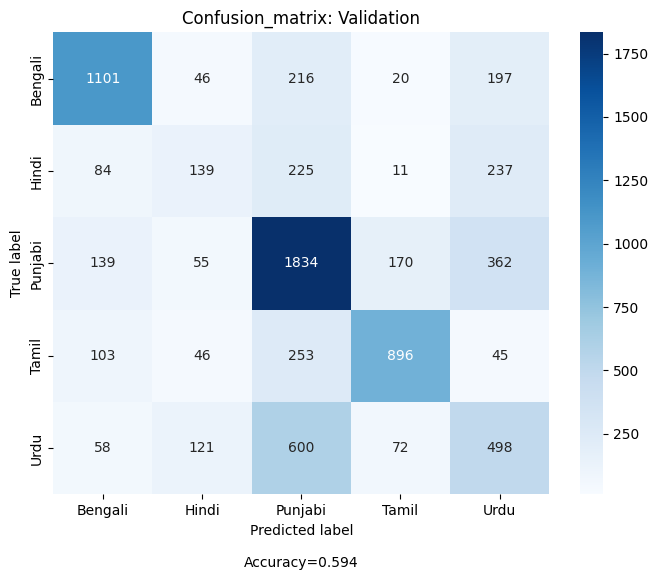

:::::Total vlidation loss 5.066371119263974, Training accuracy 0.9935365722288053, Validation accuracy 0.5935175345377258 after 11 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 12, Batch: 0, Loss: 0.1436546891927719, Accuracy:99.33333333333333%
Epoch: 12, Batch: 50, Loss: 0.17673897743225098, Accuracy:99.0%
Epoch: 12, Batch: 100, Loss: 0.06486959755420685, Accuracy:99.66666666666667%
Epoch: 12, Batch: 150, Loss: 0.07218655198812485, Accuracy:99.66666666666667%
Epoch: 12, Batch: 200, Loss: 0.17422160506248474, Accuracy:99.33333333333333%
Epoch: 12, Batch: 250, Loss: 0.09082987904548645, Accuracy:100.0%
Epoch: 12, Batch: 300, Loss: 0.14708085358142853, Accuracy:99.33333333333333%
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 7.649550437927246, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 12, Batch: 50, Loss: 9.415794372558594, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 12, Batch: 100, Loss: 14.865586280822754, Accuracy:25.0%
#####TEST--in-domai

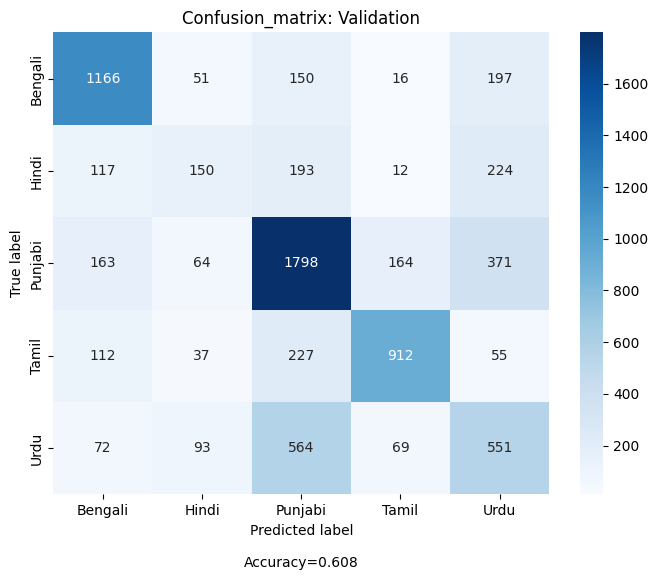

:::::Total vlidation loss 5.061153973970185, Training accuracy 0.9952405668230294, Validation accuracy 0.6079968119022316 after 12 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 13, Batch: 0, Loss: 0.10392292588949203, Accuracy:99.66666666666667%
Epoch: 13, Batch: 50, Loss: 0.07014581561088562, Accuracy:100.0%
Epoch: 13, Batch: 100, Loss: 0.1194056048989296, Accuracy:99.33333333333333%
Epoch: 13, Batch: 150, Loss: 0.05127086862921715, Accuracy:100.0%
Epoch: 13, Batch: 200, Loss: 0.12039103358983994, Accuracy:99.66666666666667%
Epoch: 13, Batch: 250, Loss: 0.10784406960010529, Accuracy:99.33333333333333%
Epoch: 13, Batch: 300, Loss: 0.08077589422464371, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 4.787871360778809, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 13, Batch: 50, Loss: 8.438394546508789, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 13, Batch: 100, Loss: 13.176656723022461, Accuracy:21.875%
#####TEST--in-domain:::::Epoc

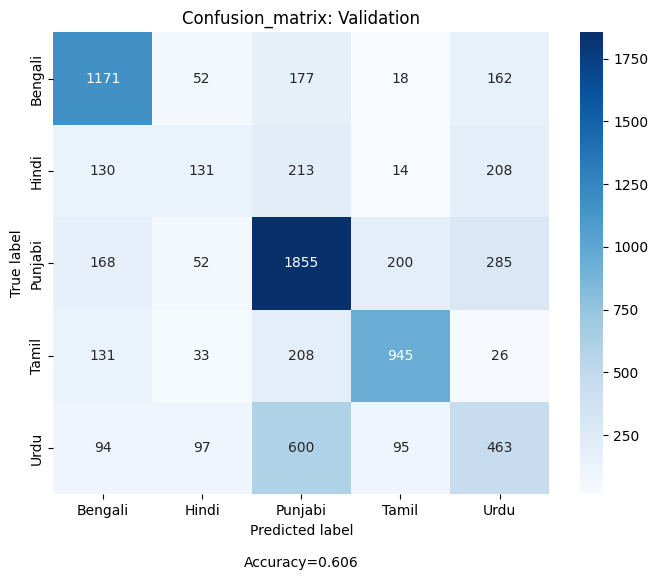

:::::Total vlidation loss 5.093273591136168, Training accuracy 0.9980315924514999, Validation accuracy 0.6064027630180658 after 13 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 14, Batch: 0, Loss: 0.0812622457742691, Accuracy:99.66666666666667%
Epoch: 14, Batch: 50, Loss: 0.11075061559677124, Accuracy:99.66666666666667%
Epoch: 14, Batch: 100, Loss: 0.04717674106359482, Accuracy:99.66666666666667%
Epoch: 14, Batch: 150, Loss: 0.14720624685287476, Accuracy:99.66666666666667%
Epoch: 14, Batch: 200, Loss: 0.07579723000526428, Accuracy:99.66666666666667%
Epoch: 14, Batch: 250, Loss: 0.05946136638522148, Accuracy:99.66666666666667%
Epoch: 14, Batch: 300, Loss: 0.0356934554874897, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 4.844837188720703, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 14, Batch: 50, Loss: 8.615262985229492, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 14, Batch: 100, Loss: 13.620262145996094, Accuracy:31.25%
###

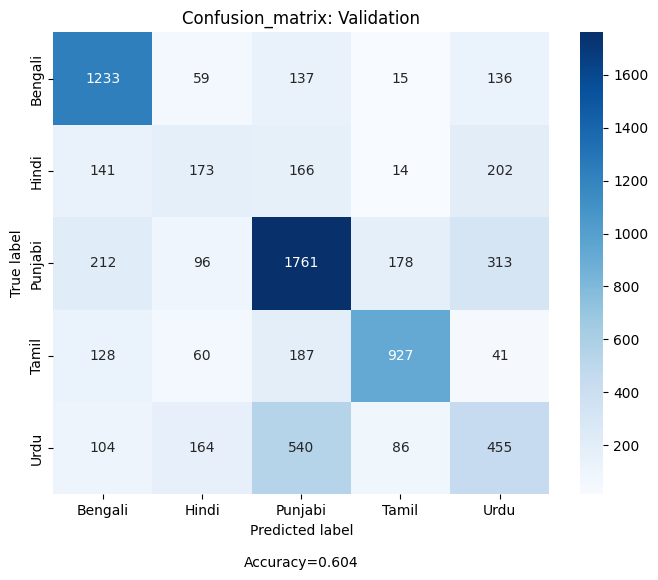

:::::Total vlidation loss 5.096060109553337, Training accuracy 0.9986583490838581, Validation accuracy 0.6042773645058448 after 14 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 15, Batch: 0, Loss: 0.021008362993597984, Accuracy:100.0%
Epoch: 15, Batch: 50, Loss: 0.01899314671754837, Accuracy:100.0%
Epoch: 15, Batch: 100, Loss: 0.025918517261743546, Accuracy:100.0%
Epoch: 15, Batch: 150, Loss: 0.027972005307674408, Accuracy:100.0%
Epoch: 15, Batch: 200, Loss: 0.07324668765068054, Accuracy:99.66666666666667%
Epoch: 15, Batch: 250, Loss: 0.02049156278371811, Accuracy:100.0%
Epoch: 15, Batch: 300, Loss: 0.05461668595671654, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 6.807024002075195, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 15, Batch: 50, Loss: 8.450043678283691, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 15, Batch: 100, Loss: 13.63282585144043, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 15, Batch: 150, Loss: 0.8474

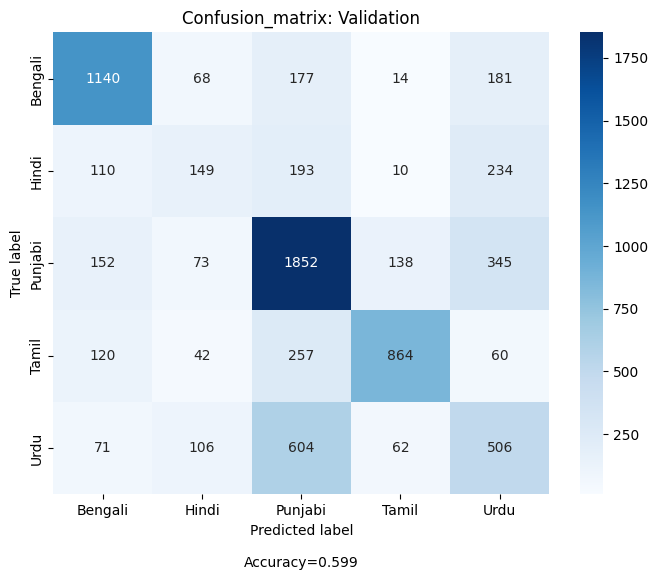

:::::Total vlidation loss 5.383817824935533, Training accuracy 0.9990402789067014, Validation accuracy 0.5992295430393199 after 15 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 16, Batch: 0, Loss: 0.05174378678202629, Accuracy:100.0%
Epoch: 16, Batch: 50, Loss: 0.017914969474077225, Accuracy:100.0%
Epoch: 16, Batch: 100, Loss: 0.09744913130998611, Accuracy:99.66666666666667%
Epoch: 16, Batch: 150, Loss: 0.044660139828920364, Accuracy:100.0%
Epoch: 16, Batch: 200, Loss: 0.02129710279405117, Accuracy:100.0%
Epoch: 16, Batch: 250, Loss: 0.05019661411643028, Accuracy:100.0%
Epoch: 16, Batch: 300, Loss: 0.014086936600506306, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 5.145778179168701, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 16, Batch: 50, Loss: 7.386199951171875, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 16, Batch: 100, Loss: 13.476686477661133, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 16, Batch: 150, Loss: 1.455

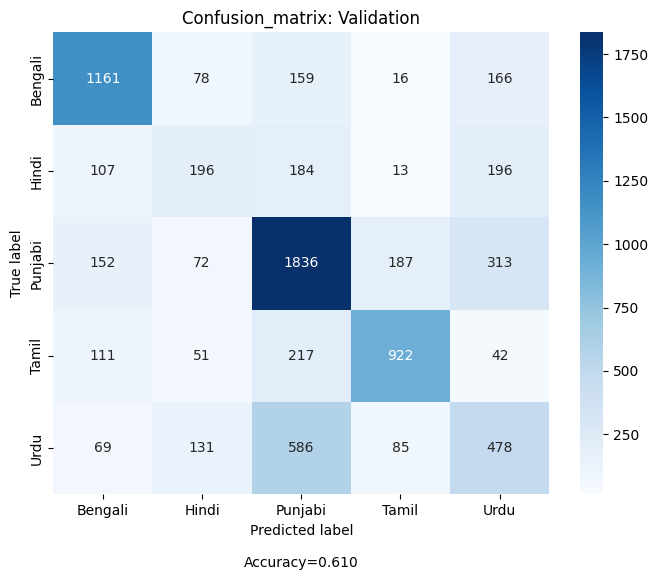

:::::Total vlidation loss 5.150063315152836, Training accuracy 0.9989717274000373, Validation accuracy 0.6101222104144527 after 16 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 17, Batch: 0, Loss: 0.06220853701233864, Accuracy:99.66666666666667%
Epoch: 17, Batch: 50, Loss: 0.020507285371422768, Accuracy:100.0%
Epoch: 17, Batch: 100, Loss: 0.04551542550325394, Accuracy:100.0%
Epoch: 17, Batch: 150, Loss: 0.03480269014835358, Accuracy:100.0%
Epoch: 17, Batch: 200, Loss: 0.020514102652668953, Accuracy:100.0%
Epoch: 17, Batch: 250, Loss: 0.02444256655871868, Accuracy:100.0%
Epoch: 17, Batch: 300, Loss: 0.025812214240431786, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 6.022982597351074, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 50, Loss: 9.120452880859375, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 100, Loss: 13.222380638122559, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 17, Batch: 150, Loss: 0.90428

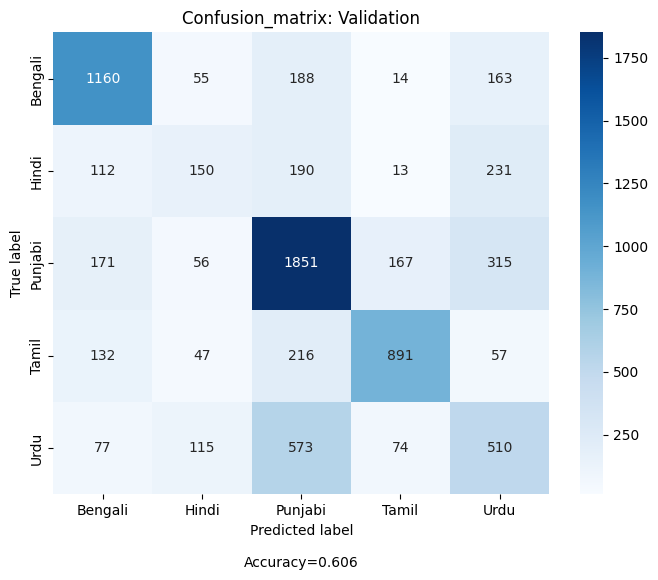

:::::Total vlidation loss 5.239179279920972, Training accuracy 0.999559311742873, Validation accuracy 0.6060042507970245 after 17 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 18, Batch: 0, Loss: 0.017168516293168068, Accuracy:100.0%
Epoch: 18, Batch: 50, Loss: 0.007685123942792416, Accuracy:100.0%
Epoch: 18, Batch: 100, Loss: 0.015377989038825035, Accuracy:100.0%
Epoch: 18, Batch: 150, Loss: 0.016908949241042137, Accuracy:100.0%
Epoch: 18, Batch: 200, Loss: 0.026836013421416283, Accuracy:100.0%
Epoch: 18, Batch: 250, Loss: 0.018243616446852684, Accuracy:100.0%
Epoch: 18, Batch: 300, Loss: 0.005580035969614983, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 6.564889907836914, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 18, Batch: 50, Loss: 8.988123893737793, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 18, Batch: 100, Loss: 15.853428840637207, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 18, Batch: 150, Loss: 1.8993036746

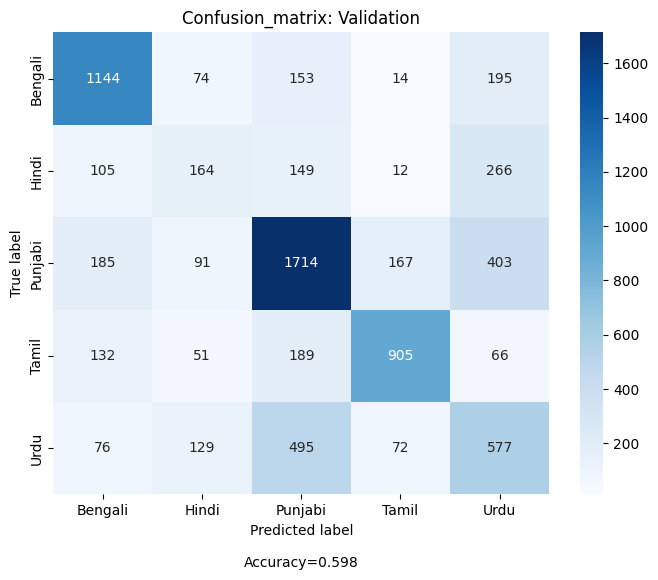

:::::Total vlidation loss 5.292780665605771, Training accuracy 0.9996768286114402, Validation accuracy 0.5982996811902231 after 18 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 19, Batch: 0, Loss: 0.011995689943432808, Accuracy:100.0%
Epoch: 19, Batch: 50, Loss: 0.041087616235017776, Accuracy:100.0%
Epoch: 19, Batch: 100, Loss: 0.009764093905687332, Accuracy:100.0%
Epoch: 19, Batch: 150, Loss: 0.021998949348926544, Accuracy:100.0%
Epoch: 19, Batch: 200, Loss: 0.025017740204930305, Accuracy:100.0%
Epoch: 19, Batch: 250, Loss: 0.007021837867796421, Accuracy:100.0%
Epoch: 19, Batch: 300, Loss: 0.03595679625868797, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 5.272313594818115, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 19, Batch: 50, Loss: 8.039688110351562, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 19, Batch: 100, Loss: 14.565113067626953, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 150, Loss: 1.064788699150

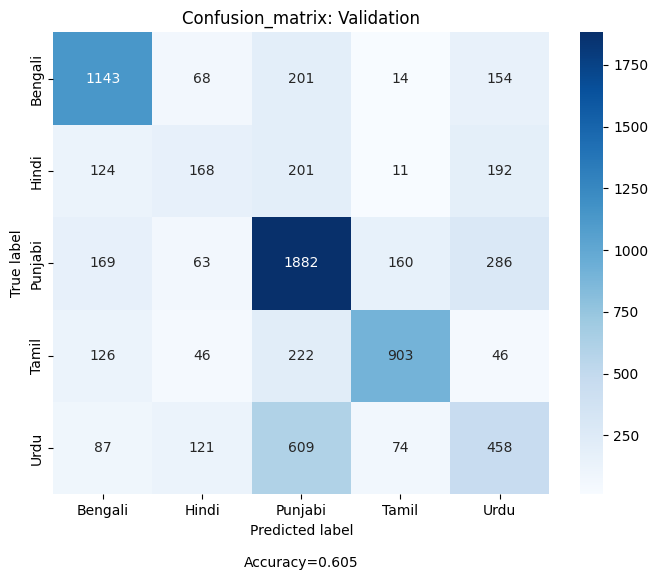

:::::Total vlidation loss 5.39633717800789, Training accuracy 0.9997845524076269, Validation accuracy 0.6049415515409139 after 19 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 20, Batch: 0, Loss: 0.009818603284657001, Accuracy:100.0%
Epoch: 20, Batch: 50, Loss: 0.009151190519332886, Accuracy:100.0%
Epoch: 20, Batch: 100, Loss: 0.003717611311003566, Accuracy:100.0%
Epoch: 20, Batch: 150, Loss: 0.01841290295124054, Accuracy:100.0%
Epoch: 20, Batch: 200, Loss: 0.03524743393063545, Accuracy:100.0%
Epoch: 20, Batch: 250, Loss: 0.006508147809654474, Accuracy:100.0%
Epoch: 20, Batch: 300, Loss: 0.01896662265062332, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 5.337193965911865, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 50, Loss: 10.061726570129395, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 100, Loss: 14.86785888671875, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 20, Batch: 150, Loss: 1.4100714921951294,

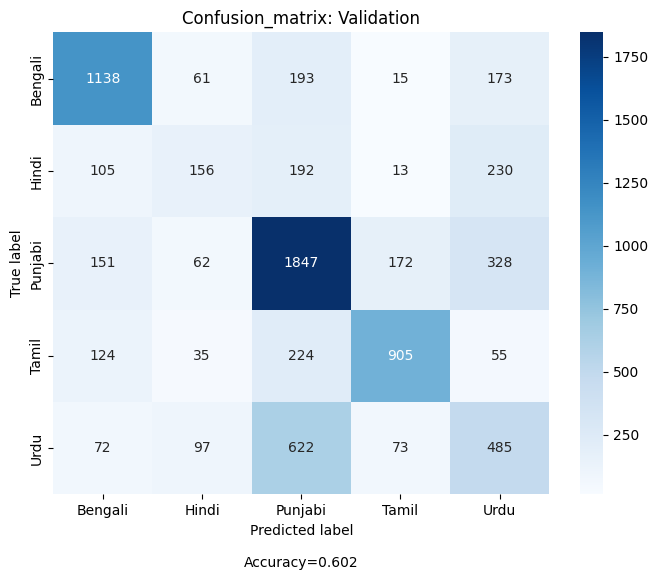

:::::Total vlidation loss 5.545894496544187, Training accuracy 0.999755173190485, Validation accuracy 0.6018862911795961 after 20 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 21, Batch: 0, Loss: 0.004773914348334074, Accuracy:100.0%
Epoch: 21, Batch: 50, Loss: 0.014999598264694214, Accuracy:100.0%
Epoch: 21, Batch: 100, Loss: 0.020141899585723877, Accuracy:100.0%
Epoch: 21, Batch: 150, Loss: 0.003329850733280182, Accuracy:100.0%


KeyboardInterrupt: 

: 

In [13]:
#For LR scheduler
import warnings
warnings.filterwarnings('ignore')
dest_path="/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/"
os.makedirs(dest_path,exist_ok=True)
#Languages=["Assamese","Bengali","Bodo","Dogri","English","Gujarati","Hindi","Kannada","Kashmiri","Konkani","Maithili","Manipuri","Malayalam","Marathi","Nepali","Odia","Punjabi","Sanskrit","Santali","Sindhi","Tamil","Telugu","Urdu"]
Languages=["Bengali","Hindi","Punjabi","Tamil","Urdu"]
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cf_matrix
def train(dataloader_train,epoch):
    train_loss_list=[]
    train_acc_list=[]
    full_preds=[]
    full_gts=[]

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data
        #features=torch.transpose(features,0,2,1)
        #print(features.shape)
        #print(labels.shape)
        #features=minmax(features)
        features, labels = features.to(device).float(),labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits = model(features)
        loss=model.get_loss(pred_logits,labels)
        posterior=model.get_posterior()
        #print(posterior.shape)
        #loss = loss_fun(pred_logits,labels)

        #print(pred_logits.shape)
        #LOSS=[]
        #for ii in range(features.shape[1]):
        #    loss = loss_fun(features[:,ii,:],labels)
        #    LOSS.append(loss)
        #loss=torch.mean(torch.tensor(LOSS))
        #loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
        if i_batch%50==0:
            #print(final_pred)
            acc = accuracy_score(predictions,labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
        train_loss_list.append(loss.item())
        for pred in predictions:
            full_preds.append(pred)
        for lab in labels.detach().cpu().numpy():
            full_gts.append(lab)
    mean_acc = accuracy_score(full_gts,full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    return mean_acc
    print('Total training loss {} and training Accuracy {} after {} epochs'.format(mean_loss,mean_acc,epoch))
def validation(dataloader_val,epoch,train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list=[]
        full_preds=[]
        full_gts=[]
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            #features=torch.transpose(features,0,2,1)
            features, labels = features.to(device).float(),labels.to(device).long()
            pred_logits = model(features)
            #print(features.shape)
            #print(labels.shape)
            loss=model.get_loss(pred_logits,labels)
            posterior=model.get_posterior()
            #loss = loss_fun(pred_logits,labels)
            val_loss_list.append(loss.item())
            predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
            if i_batch%50==0:
                #print(final_pred)
                acc = accuracy_score(predictions,labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            for pred in predictions:
                full_preds.append(pred)
            for lab in labels.detach().cpu().numpy():
                full_gts.append(lab)

        mean_acc2 = accuracy_score(full_gts,full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm=confusion_matrix(full_gts,full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8,6), categories=Languages, cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(':::::Total vlidation loss {}, Training accuracy {}, Validation accuracy {} after {} epochs'.format(mean_loss2,train_accuracy, mean_acc2,epoch))
        print("#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############")
        model_save_path = os.path.join(dest_path,'IIITH_merged_original_Bhagya_ecapa_cms_'+str("{:.3f}".format(train_accuracy*100))+"_"+str("{:.3f}".format(mean_acc2*100))+"_"+str("{:.4f}".format(mean_loss2)))
        state_dict = {'model': model.state_dict(),'optimizer': optimizer.state_dict(),'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return loss

if __name__ == '__main__':
    for epoch in range(50):
        mean_acc=train(trainloader,epoch)
        val_loss=validation(testloader1,epoch,mean_acc)
        scheduler.step(val_loss)
        #testing(testloader2,epoch,mean_acc)
        #testing(testloader3,epoch,mean_acc)